<a href="https://colab.research.google.com/github/zahraDehghanian97/Adversarially-Learned-Anomaly-Detection/blob/master/toy_experiments/ALAD%20-%20toy%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ALAD - Toy examples

### Imports

In [2]:
%matplotlib inline
import os
import pdb
import sys
py_file_location = "/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection/toy_experiments/utils"
sys.path.append(os.path.abspath(py_file_location))

In [3]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from data_gmm import GMM_distribution, sample_GMM, plot_GMM
from data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

slim = tf.contrib.slim
ds = tf.contrib.distributions
graph_replace = tf.contrib.graph_editor.graph_replace

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Parameters

In [4]:
DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100

In [5]:
""" parameters """
n_epoch = 300
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [6]:
""" Create directory for results """
result_dir = ' "/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection/toy_experiments/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [7]:
""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],[-2, -2],[2, -2],[-2, 2],[0, 0]])
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]
    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,variances=variances_x,priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x

You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset

In [8]:
dataset_x = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_train.png'


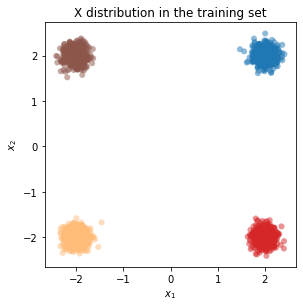

In [9]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

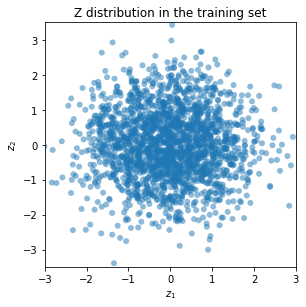

In [10]:
# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()

## Network

In [11]:
""" Networks """

def generative_network(z, input_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("generative", reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, input_dim, activation_fn=None)
    return x


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("inference", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        z = slim.fully_connected(h, latent_dim, activation_fn=None)      
    return z

def data_network_xz(x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
    """Approximate x log data density."""
    h = tf.concat([x,z], 1)
    with tf.variable_scope('discriminator', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_xx(x,x_hat, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([x,x_hat], 1)
    with tf.variable_scope('discriminator_xx', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_zz(z, z_prime, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([z, z_prime], 1)
    with tf.variable_scope('discriminator_zz', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

In [12]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, input_dim))
z = tf.placeholder(tf.float32, shape=(None, latent_dim))

# decoder and encoder
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
q_z = inference_network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)

decoder_logit = data_network_xz(p_x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit = graph_replace(decoder_logit, {p_x: x, z:q_z})

decoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(decoder_logit), logits=decoder_logit)
encoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(encoder_logit), logits=encoder_logit)

dis_loss_xz = tf.reduce_mean(encoder_loss) + tf.reduce_mean(decoder_loss)

rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, reuse=True)
rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, reuse=True)

x_logit_real = data_network_xx(x, x)
x_logit_fake = data_network_xx(x, rec_x, reuse=True)
z_logit_real = data_network_zz(z, z)
z_logit_fake = data_network_zz(z, rec_z,  reuse=True)

x_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.ones_like(x_logit_real))
x_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.zeros_like(x_logit_fake))

z_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.ones_like(z_logit_real))
z_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.zeros_like(z_logit_fake))

x_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.zeros_like(x_logit_real))
x_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.ones_like(x_logit_fake))

z_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.zeros_like(z_logit_real))
z_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.ones_like(z_logit_fake))


dis_loss_x = tf.reduce_mean(x_sigmoid_real + x_sigmoid_fake)
dis_loss_z = tf.reduce_mean(z_sigmoid_real + z_sigmoid_fake)
disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

cost_x = tf.reduce_mean(x_sigmoid_real2 + x_sigmoid_fake2) # + tf.reduce_mean(tf.pow(x_feature_real - x_feature_fake, 2))
cost_z = tf.reduce_mean(z_sigmoid_real2 + z_sigmoid_fake2) # + tf.reduce_mean(tf.pow(z_feature_real - z_feature_fake, 2))


decoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(decoder_logit), logits=decoder_logit)
encoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(encoder_logit), logits=encoder_logit)

gen_loss_xz = tf.reduce_mean(decoder_loss2)  + tf.reduce_mean(encoder_loss2)

gen_loss = gen_loss_xz + cost_x  + cost_z

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
dvars_xx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_xx")
dvars_zz = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_zz")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars + dvars_xx)

mahalanobis_dis_z = tf.norm(q_z, ord=2, axis=1, keep_dims=False, name='z_scores')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Training

In [13]:
""" training """
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    i = 0
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        i = i + 1
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):
            f_g, _ = sess.run([[gen_loss, gen_loss_xz, cost_x], train_gen_op], feed_dict={x: xmb, z:zmb})

        FG.append(f_g)
        FD.append(f_d)

    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))

  1%|          | 2/300 [00:02<04:27,  1.12it/s]

epoch 0 iter 2: discloss 4.263704 genloss 3.862092 adv_x 1.294884 recons_x 1.209003 
epoch 1 iter 2: discloss 4.783715 genloss 4.105877 adv_x 1.379242 recons_x 1.449537 


  1%|▏         | 4/300 [00:02<01:54,  2.59it/s]

epoch 2 iter 2: discloss 4.419124 genloss 4.102376 adv_x 1.143607 recons_x 1.552379 
epoch 3 iter 2: discloss 4.170048 genloss 4.166637 adv_x 1.255207 recons_x 1.505735 


  2%|▏         | 6/300 [00:02<01:08,  4.27it/s]

epoch 4 iter 2: discloss 4.124133 genloss 4.257042 adv_x 1.284837 recons_x 1.514510 
epoch 5 iter 2: discloss 4.092312 genloss 4.291568 adv_x 1.316066 recons_x 1.527417 


  3%|▎         | 8/300 [00:02<00:49,  5.86it/s]

epoch 6 iter 2: discloss 4.149500 genloss 4.194741 adv_x 1.305454 recons_x 1.478660 
epoch 7 iter 2: discloss 4.269823 genloss 4.194845 adv_x 1.364753 recons_x 1.433484 


  3%|▎         | 10/300 [00:03<00:41,  7.00it/s]

epoch 8 iter 2: discloss 4.141364 genloss 4.211548 adv_x 1.391896 recons_x 1.417952 
epoch 9 iter 2: discloss 4.210722 genloss 4.155624 adv_x 1.356309 recons_x 1.391451 


  4%|▍         | 12/300 [00:03<00:36,  7.84it/s]

epoch 10 iter 2: discloss 4.172988 genloss 4.215824 adv_x 1.413417 recons_x 1.404600 
epoch 11 iter 2: discloss 4.119807 genloss 4.197052 adv_x 1.388741 recons_x 1.414958 


  5%|▍         | 14/300 [00:03<00:34,  8.24it/s]

epoch 12 iter 2: discloss 4.131539 genloss 4.205563 adv_x 1.415662 recons_x 1.395158 
epoch 13 iter 2: discloss 4.126507 genloss 4.210283 adv_x 1.422212 recons_x 1.391706 


  5%|▌         | 16/300 [00:03<00:34,  8.30it/s]

epoch 14 iter 2: discloss 4.118803 genloss 4.208601 adv_x 1.420369 recons_x 1.392624 
epoch 15 iter 2: discloss 4.115567 genloss 4.212056 adv_x 1.409032 recons_x 1.401870 


  6%|▌         | 18/300 [00:04<00:33,  8.50it/s]

epoch 16 iter 2: discloss 4.117861 genloss 4.207265 adv_x 1.408156 recons_x 1.395470 
epoch 17 iter 2: discloss 4.117929 genloss 4.205995 adv_x 1.407593 recons_x 1.395959 


  7%|▋         | 20/300 [00:04<00:32,  8.55it/s]

epoch 18 iter 2: discloss 4.116965 genloss 4.206745 adv_x 1.402697 recons_x 1.397788 
epoch 19 iter 2: discloss 4.116364 genloss 4.213657 adv_x 1.407133 recons_x 1.400351 


  7%|▋         | 22/300 [00:04<00:32,  8.64it/s]

epoch 20 iter 2: discloss 4.124701 genloss 4.219938 adv_x 1.371123 recons_x 1.432934 
epoch 21 iter 2: discloss 4.096795 genloss 4.224843 adv_x 1.430765 recons_x 1.393701 


  8%|▊         | 24/300 [00:04<00:31,  8.64it/s]

epoch 22 iter 2: discloss 4.138551 genloss 4.272935 adv_x 1.425027 recons_x 1.436808 
epoch 23 iter 2: discloss 4.096414 genloss 4.201225 adv_x 1.395339 recons_x 1.394994 


  9%|▊         | 26/300 [00:04<00:31,  8.66it/s]

epoch 24 iter 2: discloss 4.133917 genloss 4.206798 adv_x 1.388587 recons_x 1.399764 
epoch 25 iter 2: discloss 4.126374 genloss 4.192646 adv_x 1.391190 recons_x 1.392580 


  9%|▉         | 28/300 [00:05<00:31,  8.68it/s]

epoch 26 iter 2: discloss 4.141910 genloss 4.211047 adv_x 1.414848 recons_x 1.394024 
epoch 27 iter 2: discloss 4.108341 genloss 4.231022 adv_x 1.394800 recons_x 1.424110 


 10%|█         | 30/300 [00:05<00:31,  8.69it/s]

epoch 28 iter 2: discloss 4.064167 genloss 4.327108 adv_x 1.399892 recons_x 1.480826 
epoch 29 iter 2: discloss 4.074619 genloss 4.215691 adv_x 1.418613 recons_x 1.395083 


 11%|█         | 32/300 [00:05<00:30,  8.71it/s]

epoch 30 iter 2: discloss 4.162483 genloss 4.189905 adv_x 1.380267 recons_x 1.399645 
epoch 31 iter 2: discloss 4.105764 genloss 4.209348 adv_x 1.407347 recons_x 1.394291 


 11%|█▏        | 34/300 [00:05<00:30,  8.74it/s]

epoch 32 iter 2: discloss 4.137120 genloss 4.195817 adv_x 1.401106 recons_x 1.392780 
epoch 33 iter 2: discloss 4.114482 genloss 4.211485 adv_x 1.419560 recons_x 1.390830 


 12%|█▏        | 36/300 [00:06<00:30,  8.65it/s]

epoch 34 iter 2: discloss 4.120944 genloss 4.194762 adv_x 1.400399 recons_x 1.389910 
epoch 35 iter 2: discloss 4.137581 genloss 4.210911 adv_x 1.407805 recons_x 1.397089 


 13%|█▎        | 38/300 [00:06<00:30,  8.61it/s]

epoch 36 iter 2: discloss 4.094443 genloss 4.210050 adv_x 1.417548 recons_x 1.391186 
epoch 37 iter 2: discloss 4.123759 genloss 4.194385 adv_x 1.381997 recons_x 1.411124 


 13%|█▎        | 40/300 [00:06<00:30,  8.67it/s]

epoch 38 iter 2: discloss 4.127128 genloss 4.205743 adv_x 1.407112 recons_x 1.392203 
epoch 39 iter 2: discloss 4.101504 genloss 4.210289 adv_x 1.370310 recons_x 1.415750 


 14%|█▍        | 42/300 [00:06<00:29,  8.77it/s]

epoch 40 iter 2: discloss 4.128785 genloss 4.219629 adv_x 1.403782 recons_x 1.413049 
epoch 41 iter 2: discloss 4.135393 genloss 4.186939 adv_x 1.358454 recons_x 1.419176 


 15%|█▍        | 44/300 [00:07<00:29,  8.65it/s]

epoch 42 iter 2: discloss 4.132727 genloss 4.216897 adv_x 1.401522 recons_x 1.402803 
epoch 43 iter 2: discloss 4.138803 genloss 4.207898 adv_x 1.362397 recons_x 1.415369 


 15%|█▌        | 46/300 [00:07<00:29,  8.67it/s]

epoch 44 iter 2: discloss 4.123935 genloss 4.241803 adv_x 1.416339 recons_x 1.412585 
epoch 45 iter 2: discloss 4.121957 genloss 4.209951 adv_x 1.415589 recons_x 1.395218 


 16%|█▌        | 48/300 [00:07<00:29,  8.63it/s]

epoch 46 iter 2: discloss 4.141916 genloss 4.197855 adv_x 1.396402 recons_x 1.395847 
epoch 47 iter 2: discloss 4.124200 genloss 4.211859 adv_x 1.411474 recons_x 1.395130 


 17%|█▋        | 50/300 [00:07<00:29,  8.61it/s]

epoch 48 iter 2: discloss 4.126083 genloss 4.229163 adv_x 1.411821 recons_x 1.412627 
epoch 49 iter 2: discloss 4.109944 genloss 4.211651 adv_x 1.406781 recons_x 1.405328 


 17%|█▋        | 52/300 [00:07<00:29,  8.48it/s]

epoch 50 iter 2: discloss 4.128978 genloss 4.205391 adv_x 1.402312 recons_x 1.396952 
epoch 51 iter 2: discloss 4.125637 genloss 4.226194 adv_x 1.408646 recons_x 1.400177 


 18%|█▊        | 54/300 [00:08<00:28,  8.63it/s]

epoch 52 iter 2: discloss 4.122542 genloss 4.189470 adv_x 1.393981 recons_x 1.391688 
epoch 53 iter 2: discloss 4.120078 genloss 4.217241 adv_x 1.417799 recons_x 1.392542 


 19%|█▊        | 56/300 [00:08<00:28,  8.50it/s]

epoch 54 iter 2: discloss 4.109281 genloss 4.200161 adv_x 1.374717 recons_x 1.406631 
epoch 55 iter 2: discloss 4.123877 genloss 4.213078 adv_x 1.404792 recons_x 1.397241 


 19%|█▉        | 58/300 [00:08<00:28,  8.47it/s]

epoch 56 iter 2: discloss 4.108301 genloss 4.231438 adv_x 1.398473 recons_x 1.404007 
epoch 57 iter 2: discloss 4.101555 genloss 4.219713 adv_x 1.406569 recons_x 1.397414 


 20%|██        | 60/300 [00:08<00:28,  8.50it/s]

epoch 58 iter 2: discloss 4.106994 genloss 4.208857 adv_x 1.416761 recons_x 1.392411 
epoch 59 iter 2: discloss 4.095856 genloss 4.212633 adv_x 1.418453 recons_x 1.391829 


 21%|██        | 62/300 [00:09<00:27,  8.58it/s]

epoch 60 iter 2: discloss 4.102859 genloss 4.218010 adv_x 1.411180 recons_x 1.395895 
epoch 61 iter 2: discloss 4.119337 genloss 4.210927 adv_x 1.413827 recons_x 1.398323 


 21%|██▏       | 64/300 [00:09<00:27,  8.57it/s]

epoch 62 iter 2: discloss 4.111775 genloss 4.210663 adv_x 1.424913 recons_x 1.387697 
epoch 63 iter 2: discloss 4.109033 genloss 4.206110 adv_x 1.393092 recons_x 1.398916 


 22%|██▏       | 66/300 [00:09<00:27,  8.63it/s]

epoch 64 iter 2: discloss 4.115137 genloss 4.231813 adv_x 1.425070 recons_x 1.394783 
epoch 65 iter 2: discloss 4.122448 genloss 4.282300 adv_x 1.362109 recons_x 1.491106 


 23%|██▎       | 68/300 [00:09<00:26,  8.66it/s]

epoch 66 iter 2: discloss 4.101050 genloss 4.234818 adv_x 1.421409 recons_x 1.401999 
epoch 67 iter 2: discloss 4.095789 genloss 4.228947 adv_x 1.429841 recons_x 1.389109 


 23%|██▎       | 70/300 [00:10<00:26,  8.53it/s]

epoch 68 iter 2: discloss 4.102947 genloss 4.210430 adv_x 1.411098 recons_x 1.394119 
epoch 69 iter 2: discloss 4.100117 genloss 4.244952 adv_x 1.420375 recons_x 1.398926 


 24%|██▍       | 72/300 [00:10<00:26,  8.64it/s]

epoch 70 iter 2: discloss 4.116997 genloss 4.243775 adv_x 1.411475 recons_x 1.405214 
epoch 71 iter 2: discloss 4.111331 genloss 4.213261 adv_x 1.419097 recons_x 1.389579 


 25%|██▍       | 74/300 [00:10<00:26,  8.62it/s]

epoch 72 iter 2: discloss 4.098649 genloss 4.233613 adv_x 1.421723 recons_x 1.403962 
epoch 73 iter 2: discloss 4.081384 genloss 4.229239 adv_x 1.418047 recons_x 1.395662 


 25%|██▌       | 76/300 [00:10<00:25,  8.66it/s]

epoch 74 iter 2: discloss 4.097190 genloss 4.231382 adv_x 1.412769 recons_x 1.395003 
epoch 75 iter 2: discloss 4.088101 genloss 4.211063 adv_x 1.417173 recons_x 1.393611 


 26%|██▌       | 78/300 [00:10<00:25,  8.66it/s]

epoch 76 iter 2: discloss 4.093558 genloss 4.244251 adv_x 1.409656 recons_x 1.422149 
epoch 77 iter 2: discloss 4.109792 genloss 4.223359 adv_x 1.413754 recons_x 1.397388 


 27%|██▋       | 80/300 [00:11<00:25,  8.63it/s]

epoch 78 iter 2: discloss 4.097110 genloss 4.234257 adv_x 1.414616 recons_x 1.398786 
epoch 79 iter 2: discloss 4.084861 genloss 4.231617 adv_x 1.425218 recons_x 1.391967 


 27%|██▋       | 82/300 [00:11<00:25,  8.66it/s]

epoch 80 iter 2: discloss 4.107908 genloss 4.233139 adv_x 1.422706 recons_x 1.390666 
epoch 81 iter 2: discloss 4.096649 genloss 4.254476 adv_x 1.433325 recons_x 1.399267 


 28%|██▊       | 84/300 [00:11<00:24,  8.72it/s]

epoch 82 iter 2: discloss 4.066420 genloss 4.248721 adv_x 1.445007 recons_x 1.394244 
epoch 83 iter 2: discloss 4.083073 genloss 4.252757 adv_x 1.426212 recons_x 1.392195 


 29%|██▊       | 86/300 [00:11<00:24,  8.76it/s]

epoch 84 iter 2: discloss 4.064074 genloss 4.265854 adv_x 1.424029 recons_x 1.417025 
epoch 85 iter 2: discloss 4.070576 genloss 4.270405 adv_x 1.420867 recons_x 1.400114 


 29%|██▉       | 88/300 [00:12<00:25,  8.43it/s]

epoch 86 iter 2: discloss 4.100762 genloss 4.235843 adv_x 1.434156 recons_x 1.395363 
epoch 87 iter 2: discloss 4.062124 genloss 4.277733 adv_x 1.441042 recons_x 1.409667 


 30%|███       | 90/300 [00:12<00:24,  8.59it/s]

epoch 88 iter 2: discloss 4.076708 genloss 4.283508 adv_x 1.452768 recons_x 1.400837 
epoch 89 iter 2: discloss 4.072991 genloss 4.279340 adv_x 1.446747 recons_x 1.403242 


 31%|███       | 92/300 [00:12<00:24,  8.61it/s]

epoch 90 iter 2: discloss 4.064184 genloss 4.278440 adv_x 1.467405 recons_x 1.395485 
epoch 91 iter 2: discloss 4.069819 genloss 4.293419 adv_x 1.474069 recons_x 1.392836 


 31%|███▏      | 94/300 [00:12<00:24,  8.54it/s]

epoch 92 iter 2: discloss 4.063077 genloss 4.290936 adv_x 1.459173 recons_x 1.398414 
epoch 93 iter 2: discloss 4.043946 genloss 4.281380 adv_x 1.457198 recons_x 1.397826 


 32%|███▏      | 96/300 [00:13<00:24,  8.48it/s]

epoch 94 iter 2: discloss 4.056279 genloss 4.284681 adv_x 1.458888 recons_x 1.406053 
epoch 95 iter 2: discloss 4.059590 genloss 4.288954 adv_x 1.470704 recons_x 1.396264 


 33%|███▎      | 98/300 [00:13<00:23,  8.55it/s]

epoch 96 iter 2: discloss 4.055213 genloss 4.292812 adv_x 1.466487 recons_x 1.400309 
epoch 97 iter 2: discloss 4.074004 genloss 4.265610 adv_x 1.449340 recons_x 1.392611 


 33%|███▎      | 100/300 [00:13<00:23,  8.64it/s]

epoch 98 iter 2: discloss 4.100739 genloss 4.273755 adv_x 1.426344 recons_x 1.401499 
epoch 99 iter 2: discloss 4.080582 genloss 4.296502 adv_x 1.462917 recons_x 1.402413 


 34%|███▍      | 102/300 [00:13<00:23,  8.56it/s]

epoch 100 iter 2: discloss 4.088550 genloss 4.306079 adv_x 1.422554 recons_x 1.432071 
epoch 101 iter 2: discloss 4.124413 genloss 4.284578 adv_x 1.453633 recons_x 1.396106 


 35%|███▍      | 104/300 [00:14<00:22,  8.61it/s]

epoch 102 iter 2: discloss 4.084262 genloss 4.253215 adv_x 1.396267 recons_x 1.426134 
epoch 103 iter 2: discloss 4.077159 genloss 4.297703 adv_x 1.491225 recons_x 1.387724 


 35%|███▌      | 106/300 [00:14<00:22,  8.50it/s]

epoch 104 iter 2: discloss 4.032630 genloss 4.297574 adv_x 1.433315 recons_x 1.413834 
epoch 105 iter 2: discloss 4.062242 genloss 4.282773 adv_x 1.453764 recons_x 1.392090 


 36%|███▌      | 108/300 [00:14<00:22,  8.49it/s]

epoch 106 iter 2: discloss 4.055604 genloss 4.299613 adv_x 1.471488 recons_x 1.399197 
epoch 107 iter 2: discloss 4.072057 genloss 4.283249 adv_x 1.414207 recons_x 1.425264 


 37%|███▋      | 110/300 [00:14<00:22,  8.56it/s]

epoch 108 iter 2: discloss 4.109331 genloss 4.270718 adv_x 1.444403 recons_x 1.393016 
epoch 109 iter 2: discloss 4.073113 genloss 4.267898 adv_x 1.415192 recons_x 1.400558 


 37%|███▋      | 112/300 [00:14<00:21,  8.65it/s]

epoch 110 iter 2: discloss 4.024660 genloss 4.312179 adv_x 1.469202 recons_x 1.403623 
epoch 111 iter 2: discloss 4.110456 genloss 4.233850 adv_x 1.385420 recons_x 1.408162 


 38%|███▊      | 114/300 [00:15<00:21,  8.55it/s]

epoch 112 iter 2: discloss 4.083328 genloss 4.312417 adv_x 1.483385 recons_x 1.397507 
epoch 113 iter 2: discloss 4.079936 genloss 4.261751 adv_x 1.424349 recons_x 1.405692 


 39%|███▊      | 116/300 [00:15<00:21,  8.60it/s]

epoch 114 iter 2: discloss 4.076111 genloss 4.312439 adv_x 1.476210 recons_x 1.396177 
epoch 115 iter 2: discloss 4.088850 genloss 4.271018 adv_x 1.422614 recons_x 1.394772 


 39%|███▉      | 118/300 [00:15<00:21,  8.54it/s]

epoch 116 iter 2: discloss 4.031281 genloss 4.314147 adv_x 1.464969 recons_x 1.400136 
epoch 117 iter 2: discloss 4.124182 genloss 4.307250 adv_x 1.422009 recons_x 1.432411 


 40%|████      | 120/300 [00:15<00:21,  8.55it/s]

epoch 118 iter 2: discloss 4.067682 genloss 4.283525 adv_x 1.455948 recons_x 1.390422 
epoch 119 iter 2: discloss 4.104043 genloss 4.313622 adv_x 1.476156 recons_x 1.402584 


 41%|████      | 122/300 [00:16<00:21,  8.45it/s]

epoch 120 iter 2: discloss 4.083770 genloss 4.234951 adv_x 1.389974 recons_x 1.402623 
epoch 121 iter 2: discloss 4.084717 genloss 4.381577 adv_x 1.535829 recons_x 1.399572 


 41%|████▏     | 124/300 [00:16<00:20,  8.57it/s]

epoch 122 iter 2: discloss 4.113459 genloss 4.257424 adv_x 1.414795 recons_x 1.395993 
epoch 123 iter 2: discloss 4.087306 genloss 4.308056 adv_x 1.482183 recons_x 1.397813 


 42%|████▏     | 126/300 [00:16<00:20,  8.51it/s]

epoch 124 iter 2: discloss 4.067389 genloss 4.243224 adv_x 1.380327 recons_x 1.403706 
epoch 125 iter 2: discloss 4.060186 genloss 4.331639 adv_x 1.479006 recons_x 1.401629 


 43%|████▎     | 128/300 [00:16<00:20,  8.59it/s]

epoch 126 iter 2: discloss 4.086150 genloss 4.246974 adv_x 1.409327 recons_x 1.402919 
epoch 127 iter 2: discloss 4.068204 genloss 4.285604 adv_x 1.419845 recons_x 1.394563 


 43%|████▎     | 130/300 [00:17<00:19,  8.51it/s]

epoch 128 iter 2: discloss 4.070384 genloss 4.293931 adv_x 1.453734 recons_x 1.395595 
epoch 129 iter 2: discloss 4.069563 genloss 4.250374 adv_x 1.430440 recons_x 1.389282 


 44%|████▍     | 132/300 [00:17<00:19,  8.54it/s]

epoch 130 iter 2: discloss 4.072261 genloss 4.310570 adv_x 1.480847 recons_x 1.392359 
epoch 131 iter 2: discloss 4.082806 genloss 4.260772 adv_x 1.426746 recons_x 1.393251 


 45%|████▍     | 134/300 [00:17<00:19,  8.65it/s]

epoch 132 iter 2: discloss 4.083232 genloss 4.274710 adv_x 1.443472 recons_x 1.386517 
epoch 133 iter 2: discloss 4.067911 genloss 4.266288 adv_x 1.428059 recons_x 1.393288 


 45%|████▌     | 136/300 [00:17<00:19,  8.63it/s]

epoch 134 iter 2: discloss 4.101557 genloss 4.287210 adv_x 1.445310 recons_x 1.397111 
epoch 135 iter 2: discloss 4.080328 genloss 4.312433 adv_x 1.441951 recons_x 1.407018 


 46%|████▌     | 138/300 [00:17<00:18,  8.74it/s]

epoch 136 iter 2: discloss 4.055163 genloss 4.232442 adv_x 1.366225 recons_x 1.400854 
epoch 137 iter 2: discloss 4.093559 genloss 4.315790 adv_x 1.480617 recons_x 1.388644 


 47%|████▋     | 140/300 [00:18<00:18,  8.60it/s]

epoch 138 iter 2: discloss 4.118238 genloss 4.253978 adv_x 1.417544 recons_x 1.393896 
epoch 139 iter 2: discloss 4.011351 genloss 4.352932 adv_x 1.481729 recons_x 1.399544 


 47%|████▋     | 142/300 [00:18<00:18,  8.61it/s]

epoch 140 iter 2: discloss 4.095687 genloss 4.252074 adv_x 1.422870 recons_x 1.388554 
epoch 141 iter 2: discloss 4.078645 genloss 4.232722 adv_x 1.406788 recons_x 1.394883 


 48%|████▊     | 144/300 [00:18<00:18,  8.44it/s]

epoch 142 iter 2: discloss 4.056391 genloss 4.287724 adv_x 1.442256 recons_x 1.397679 
epoch 143 iter 2: discloss 4.060146 genloss 4.281688 adv_x 1.456494 recons_x 1.386811 


 49%|████▊     | 146/300 [00:18<00:18,  8.46it/s]

epoch 144 iter 2: discloss 4.058920 genloss 4.343570 adv_x 1.419237 recons_x 1.408564 
epoch 145 iter 2: discloss 4.073400 genloss 4.265928 adv_x 1.424634 recons_x 1.395830 


 49%|████▉     | 148/300 [00:19<00:17,  8.49it/s]

epoch 146 iter 2: discloss 4.048956 genloss 4.287012 adv_x 1.410193 recons_x 1.411066 
epoch 147 iter 2: discloss 4.040135 genloss 4.330632 adv_x 1.464211 recons_x 1.392500 


 50%|█████     | 150/300 [00:19<00:17,  8.60it/s]

epoch 148 iter 2: discloss 4.081278 genloss 4.270601 adv_x 1.413572 recons_x 1.396039 
epoch 149 iter 2: discloss 4.029622 genloss 4.337165 adv_x 1.498520 recons_x 1.404725 


 51%|█████     | 152/300 [00:19<00:17,  8.67it/s]

epoch 150 iter 2: discloss 4.009965 genloss 4.324621 adv_x 1.431906 recons_x 1.393687 
epoch 151 iter 2: discloss 3.849780 genloss 4.376336 adv_x 1.480799 recons_x 1.398422 


 51%|█████▏    | 154/300 [00:19<00:17,  8.51it/s]

epoch 152 iter 2: discloss 4.039789 genloss 4.280622 adv_x 1.452058 recons_x 1.391684 
epoch 153 iter 2: discloss 4.071183 genloss 4.309637 adv_x 1.414348 recons_x 1.406964 


 52%|█████▏    | 156/300 [00:20<00:16,  8.52it/s]

epoch 154 iter 2: discloss 4.089403 genloss 4.301878 adv_x 1.443327 recons_x 1.402271 
epoch 155 iter 2: discloss 4.069663 genloss 4.339756 adv_x 1.425991 recons_x 1.435254 


 53%|█████▎    | 158/300 [00:20<00:16,  8.55it/s]

epoch 156 iter 2: discloss 3.996499 genloss 4.251956 adv_x 1.437427 recons_x 1.389069 
epoch 157 iter 2: discloss 4.078422 genloss 4.302458 adv_x 1.458606 recons_x 1.393427 


 53%|█████▎    | 160/300 [00:20<00:16,  8.62it/s]

epoch 158 iter 2: discloss 4.039957 genloss 4.313646 adv_x 1.460265 recons_x 1.393858 
epoch 159 iter 2: discloss 4.037626 genloss 4.282015 adv_x 1.441941 recons_x 1.386534 


 54%|█████▍    | 162/300 [00:20<00:16,  8.60it/s]

epoch 160 iter 2: discloss 4.098131 genloss 4.278162 adv_x 1.445092 recons_x 1.395904 
epoch 161 iter 2: discloss 4.070714 genloss 4.290923 adv_x 1.364083 recons_x 1.427559 


 55%|█████▍    | 164/300 [00:21<00:15,  8.62it/s]

epoch 162 iter 2: discloss 4.103312 genloss 4.329978 adv_x 1.436523 recons_x 1.399689 
epoch 163 iter 2: discloss 4.065239 genloss 4.264481 adv_x 1.400719 recons_x 1.398051 


 55%|█████▌    | 166/300 [00:21<00:15,  8.52it/s]

epoch 164 iter 2: discloss 4.124002 genloss 4.350495 adv_x 1.473014 recons_x 1.396956 
epoch 165 iter 2: discloss 4.053288 genloss 4.344052 adv_x 1.468961 recons_x 1.400578 


 56%|█████▌    | 168/300 [00:21<00:15,  8.54it/s]

epoch 166 iter 2: discloss 4.010165 genloss 4.269652 adv_x 1.360030 recons_x 1.423285 
epoch 167 iter 2: discloss 4.099340 genloss 4.238038 adv_x 1.390197 recons_x 1.393391 


 57%|█████▋    | 170/300 [00:21<00:15,  8.59it/s]

epoch 168 iter 2: discloss 4.051103 genloss 4.333896 adv_x 1.460909 recons_x 1.394635 
epoch 169 iter 2: discloss 4.059402 genloss 4.289618 adv_x 1.443479 recons_x 1.385985 


 57%|█████▋    | 172/300 [00:21<00:14,  8.54it/s]

epoch 170 iter 2: discloss 4.059560 genloss 4.307180 adv_x 1.447037 recons_x 1.391240 
epoch 171 iter 2: discloss 4.017677 genloss 4.286035 adv_x 1.440211 recons_x 1.395051 


 58%|█████▊    | 174/300 [00:22<00:15,  8.29it/s]

epoch 172 iter 2: discloss 4.057306 genloss 4.278333 adv_x 1.402800 recons_x 1.398578 
epoch 173 iter 2: discloss 4.094660 genloss 4.275205 adv_x 1.401027 recons_x 1.400578 


 59%|█████▊    | 176/300 [00:22<00:14,  8.46it/s]

epoch 174 iter 2: discloss 4.049523 genloss 4.313332 adv_x 1.469073 recons_x 1.387412 
epoch 175 iter 2: discloss 4.025093 genloss 4.362166 adv_x 1.463859 recons_x 1.401362 


 59%|█████▉    | 178/300 [00:22<00:14,  8.58it/s]

epoch 176 iter 2: discloss 4.057366 genloss 4.253969 adv_x 1.411079 recons_x 1.388087 
epoch 177 iter 2: discloss 4.036701 genloss 4.288172 adv_x 1.439973 recons_x 1.396021 


 60%|██████    | 180/300 [00:22<00:14,  8.52it/s]

epoch 178 iter 2: discloss 4.014193 genloss 4.330353 adv_x 1.444211 recons_x 1.403381 
epoch 179 iter 2: discloss 4.066892 genloss 4.284346 adv_x 1.399210 recons_x 1.400410 


 61%|██████    | 182/300 [00:23<00:13,  8.46it/s]

epoch 180 iter 2: discloss 4.048845 genloss 4.360627 adv_x 1.454234 recons_x 1.401898 
epoch 181 iter 2: discloss 4.020354 genloss 4.306541 adv_x 1.452453 recons_x 1.387900 


 61%|██████▏   | 184/300 [00:23<00:13,  8.50it/s]

epoch 182 iter 2: discloss 4.018383 genloss 4.326025 adv_x 1.463508 recons_x 1.398593 
epoch 183 iter 2: discloss 4.034708 genloss 4.324677 adv_x 1.466476 recons_x 1.394239 


 62%|██████▏   | 186/300 [00:23<00:13,  8.61it/s]

epoch 184 iter 2: discloss 4.046628 genloss 4.310488 adv_x 1.442052 recons_x 1.401839 
epoch 185 iter 2: discloss 4.045594 genloss 4.335557 adv_x 1.454551 recons_x 1.396783 


 63%|██████▎   | 188/300 [00:23<00:13,  8.59it/s]

epoch 186 iter 2: discloss 4.026408 genloss 4.308513 adv_x 1.453953 recons_x 1.393412 
epoch 187 iter 2: discloss 4.040156 genloss 4.378769 adv_x 1.472878 recons_x 1.397859 


 63%|██████▎   | 190/300 [00:24<00:12,  8.64it/s]

epoch 188 iter 2: discloss 3.920325 genloss 4.323009 adv_x 1.455668 recons_x 1.396407 
epoch 189 iter 2: discloss 4.024286 genloss 4.295609 adv_x 1.446315 recons_x 1.392799 


 64%|██████▍   | 192/300 [00:24<00:12,  8.60it/s]

epoch 190 iter 2: discloss 4.025946 genloss 4.377403 adv_x 1.509234 recons_x 1.393472 
epoch 191 iter 2: discloss 4.077691 genloss 4.287681 adv_x 1.412981 recons_x 1.390485 


 65%|██████▍   | 194/300 [00:24<00:12,  8.64it/s]

epoch 192 iter 2: discloss 3.991424 genloss 4.432775 adv_x 1.507258 recons_x 1.405896 
epoch 193 iter 2: discloss 4.059531 genloss 4.369364 adv_x 1.390828 recons_x 1.398891 


 65%|██████▌   | 196/300 [00:24<00:12,  8.62it/s]

epoch 194 iter 2: discloss 4.146610 genloss 4.222951 adv_x 1.375980 recons_x 1.398686 
epoch 195 iter 2: discloss 4.039860 genloss 4.325323 adv_x 1.458471 recons_x 1.396708 


 66%|██████▌   | 198/300 [00:25<00:11,  8.70it/s]

epoch 196 iter 2: discloss 4.045211 genloss 4.393544 adv_x 1.497111 recons_x 1.394243 
epoch 197 iter 2: discloss 4.016822 genloss 4.388896 adv_x 1.431560 recons_x 1.396468 


 67%|██████▋   | 200/300 [00:25<00:11,  8.60it/s]

epoch 198 iter 2: discloss 4.050879 genloss 4.336184 adv_x 1.478932 recons_x 1.398162 
epoch 199 iter 2: discloss 4.048758 genloss 4.325219 adv_x 1.453780 recons_x 1.391400 


 67%|██████▋   | 202/300 [00:25<00:11,  8.62it/s]

epoch 200 iter 2: discloss 4.045450 genloss 4.309948 adv_x 1.403826 recons_x 1.404700 
epoch 201 iter 2: discloss 4.128931 genloss 4.340508 adv_x 1.403229 recons_x 1.400851 


 68%|██████▊   | 204/300 [00:25<00:11,  8.70it/s]

epoch 202 iter 2: discloss 3.971232 genloss 4.361995 adv_x 1.498681 recons_x 1.392590 
epoch 203 iter 2: discloss 4.010126 genloss 4.351472 adv_x 1.464713 recons_x 1.394239 


 69%|██████▊   | 206/300 [00:25<00:10,  8.67it/s]

epoch 204 iter 2: discloss 4.039318 genloss 4.277042 adv_x 1.403596 recons_x 1.395847 
epoch 205 iter 2: discloss 4.084767 genloss 4.336799 adv_x 1.469885 recons_x 1.395121 


 69%|██████▉   | 208/300 [00:26<00:10,  8.60it/s]

epoch 206 iter 2: discloss 3.957880 genloss 4.357146 adv_x 1.483278 recons_x 1.389446 
epoch 207 iter 2: discloss 4.073951 genloss 4.305240 adv_x 1.431504 recons_x 1.390262 


 70%|███████   | 210/300 [00:26<00:10,  8.64it/s]

epoch 208 iter 2: discloss 4.060742 genloss 4.297125 adv_x 1.444615 recons_x 1.388808 
epoch 209 iter 2: discloss 4.054596 genloss 4.310186 adv_x 1.408910 recons_x 1.399539 


 71%|███████   | 212/300 [00:26<00:10,  8.73it/s]

epoch 210 iter 2: discloss 4.084432 genloss 4.306015 adv_x 1.422724 recons_x 1.399939 
epoch 211 iter 2: discloss 4.091145 genloss 4.322968 adv_x 1.407950 recons_x 1.403892 


 71%|███████▏  | 214/300 [00:26<00:09,  8.69it/s]

epoch 212 iter 2: discloss 4.002472 genloss 4.357372 adv_x 1.519614 recons_x 1.387193 
epoch 213 iter 2: discloss 4.024131 genloss 4.347362 adv_x 1.438344 recons_x 1.394001 


 72%|███████▏  | 216/300 [00:27<00:09,  8.60it/s]

epoch 214 iter 2: discloss 4.043147 genloss 4.332256 adv_x 1.408360 recons_x 1.396725 
epoch 215 iter 2: discloss 4.022281 genloss 4.337989 adv_x 1.460556 recons_x 1.392315 


 73%|███████▎  | 218/300 [00:27<00:09,  8.52it/s]

epoch 216 iter 2: discloss 4.004181 genloss 4.303579 adv_x 1.462113 recons_x 1.388849 
epoch 217 iter 2: discloss 4.052891 genloss 4.352372 adv_x 1.431749 recons_x 1.393412 


 73%|███████▎  | 220/300 [00:27<00:09,  8.64it/s]

epoch 218 iter 2: discloss 4.039072 genloss 4.413687 adv_x 1.433901 recons_x 1.388546 
epoch 219 iter 2: discloss 4.000864 genloss 4.406465 adv_x 1.472795 recons_x 1.396934 


 74%|███████▍  | 222/300 [00:27<00:08,  8.75it/s]

epoch 220 iter 2: discloss 4.001385 genloss 4.357826 adv_x 1.442262 recons_x 1.395129 
epoch 221 iter 2: discloss 3.990095 genloss 4.314898 adv_x 1.495575 recons_x 1.387573 


 75%|███████▍  | 224/300 [00:28<00:08,  8.75it/s]

epoch 222 iter 2: discloss 4.032500 genloss 4.402885 adv_x 1.444085 recons_x 1.409591 
epoch 223 iter 2: discloss 4.028809 genloss 4.329822 adv_x 1.461108 recons_x 1.395232 


 75%|███████▌  | 226/300 [00:28<00:08,  8.62it/s]

epoch 224 iter 2: discloss 3.993458 genloss 4.433923 adv_x 1.515147 recons_x 1.391277 
epoch 225 iter 2: discloss 4.017218 genloss 4.402342 adv_x 1.420832 recons_x 1.404924 


 76%|███████▌  | 228/300 [00:28<00:08,  8.59it/s]

epoch 226 iter 2: discloss 4.076587 genloss 4.313023 adv_x 1.398279 recons_x 1.398691 
epoch 227 iter 2: discloss 4.061304 genloss 4.355626 adv_x 1.423059 recons_x 1.437724 


 77%|███████▋  | 230/300 [00:28<00:08,  8.65it/s]

epoch 228 iter 2: discloss 4.023380 genloss 4.419320 adv_x 1.476436 recons_x 1.391209 
epoch 229 iter 2: discloss 3.995568 genloss 4.388483 adv_x 1.486978 recons_x 1.390266 


 77%|███████▋  | 232/300 [00:28<00:07,  8.61it/s]

epoch 230 iter 2: discloss 4.037537 genloss 4.347874 adv_x 1.440393 recons_x 1.388644 
epoch 231 iter 2: discloss 4.053708 genloss 4.324735 adv_x 1.473703 recons_x 1.387508 


 78%|███████▊  | 234/300 [00:29<00:07,  8.40it/s]

epoch 232 iter 2: discloss 3.976974 genloss 4.386000 adv_x 1.471430 recons_x 1.404160 
epoch 233 iter 2: discloss 4.025888 genloss 4.284641 adv_x 1.392584 recons_x 1.398881 


 79%|███████▊  | 236/300 [00:29<00:07,  8.37it/s]

epoch 234 iter 2: discloss 4.119759 genloss 4.336184 adv_x 1.422497 recons_x 1.397872 
epoch 235 iter 2: discloss 4.019706 genloss 4.289019 adv_x 1.447502 recons_x 1.387823 


 79%|███████▉  | 238/300 [00:29<00:07,  8.44it/s]

epoch 236 iter 2: discloss 4.039871 genloss 4.270788 adv_x 1.447987 recons_x 1.387506 
epoch 237 iter 2: discloss 4.050934 genloss 4.362903 adv_x 1.484221 recons_x 1.395683 


 80%|████████  | 240/300 [00:29<00:07,  8.38it/s]

epoch 238 iter 2: discloss 4.000806 genloss 4.409426 adv_x 1.476166 recons_x 1.411152 
epoch 239 iter 2: discloss 3.973021 genloss 4.308723 adv_x 1.454684 recons_x 1.393505 


 81%|████████  | 242/300 [00:30<00:06,  8.56it/s]

epoch 240 iter 2: discloss 4.032516 genloss 4.344717 adv_x 1.449717 recons_x 1.401945 
epoch 241 iter 2: discloss 4.030437 genloss 4.316984 adv_x 1.455918 recons_x 1.388664 


 81%|████████▏ | 244/300 [00:30<00:06,  8.61it/s]

epoch 242 iter 2: discloss 4.079054 genloss 4.270842 adv_x 1.420914 recons_x 1.385974 
epoch 243 iter 2: discloss 4.016291 genloss 4.426167 adv_x 1.508756 recons_x 1.398168 


 82%|████████▏ | 246/300 [00:30<00:06,  8.65it/s]

epoch 244 iter 2: discloss 3.967558 genloss 4.351342 adv_x 1.468693 recons_x 1.399757 
epoch 245 iter 2: discloss 4.004321 genloss 4.337028 adv_x 1.439944 recons_x 1.386606 


 83%|████████▎ | 248/300 [00:30<00:06,  8.61it/s]

epoch 246 iter 2: discloss 4.037343 genloss 4.350744 adv_x 1.430281 recons_x 1.400080 
epoch 247 iter 2: discloss 4.026240 genloss 4.363421 adv_x 1.427356 recons_x 1.399256 


 83%|████████▎ | 250/300 [00:31<00:05,  8.70it/s]

epoch 248 iter 2: discloss 4.011772 genloss 4.345163 adv_x 1.461062 recons_x 1.389961 
epoch 249 iter 2: discloss 3.961046 genloss 4.376558 adv_x 1.491640 recons_x 1.394645 


 84%|████████▍ | 252/300 [00:31<00:05,  8.51it/s]

epoch 250 iter 2: discloss 3.947104 genloss 4.400803 adv_x 1.483109 recons_x 1.401657 
epoch 251 iter 2: discloss 4.012021 genloss 4.413079 adv_x 1.475011 recons_x 1.403681 


 85%|████████▍ | 254/300 [00:31<00:05,  8.55it/s]

epoch 252 iter 2: discloss 3.992386 genloss 4.436875 adv_x 1.456002 recons_x 1.392678 
epoch 253 iter 2: discloss 3.961661 genloss 4.371334 adv_x 1.462623 recons_x 1.398339 


 85%|████████▌ | 256/300 [00:31<00:05,  8.62it/s]

epoch 254 iter 2: discloss 3.974057 genloss 4.373597 adv_x 1.463554 recons_x 1.398412 
epoch 255 iter 2: discloss 3.958860 genloss 4.448418 adv_x 1.510124 recons_x 1.396940 


 86%|████████▌ | 258/300 [00:32<00:04,  8.65it/s]

epoch 256 iter 2: discloss 3.972335 genloss 4.415487 adv_x 1.491654 recons_x 1.392354 
epoch 257 iter 2: discloss 3.973307 genloss 4.355679 adv_x 1.488902 recons_x 1.388026 


 87%|████████▋ | 260/300 [00:32<00:04,  8.57it/s]

epoch 258 iter 2: discloss 3.966735 genloss 4.422716 adv_x 1.485532 recons_x 1.394081 
epoch 259 iter 2: discloss 3.985614 genloss 4.394723 adv_x 1.488459 recons_x 1.390940 


 87%|████████▋ | 262/300 [00:32<00:04,  8.62it/s]

epoch 260 iter 2: discloss 3.976281 genloss 4.391580 adv_x 1.506794 recons_x 1.391603 
epoch 261 iter 2: discloss 3.930578 genloss 4.336183 adv_x 1.441284 recons_x 1.394074 


 88%|████████▊ | 264/300 [00:32<00:04,  8.72it/s]

epoch 262 iter 2: discloss 4.009602 genloss 4.362251 adv_x 1.476875 recons_x 1.401893 
epoch 263 iter 2: discloss 3.932169 genloss 4.446121 adv_x 1.514832 recons_x 1.382441 


 89%|████████▊ | 266/300 [00:32<00:04,  8.47it/s]

epoch 264 iter 2: discloss 4.089307 genloss 4.341900 adv_x 1.446690 recons_x 1.394440 
epoch 265 iter 2: discloss 3.953133 genloss 4.569407 adv_x 1.589905 recons_x 1.397308 


 89%|████████▉ | 268/300 [00:33<00:03,  8.53it/s]

epoch 266 iter 2: discloss 3.991328 genloss 4.375838 adv_x 1.382025 recons_x 1.406500 
epoch 267 iter 2: discloss 4.174034 genloss 4.225711 adv_x 1.303864 recons_x 1.395656 


 90%|█████████ | 270/300 [00:33<00:03,  8.46it/s]

epoch 268 iter 2: discloss 4.135123 genloss 4.322319 adv_x 1.403878 recons_x 1.393683 
epoch 269 iter 2: discloss 4.064531 genloss 4.457720 adv_x 1.472560 recons_x 1.394133 


 91%|█████████ | 272/300 [00:33<00:03,  8.56it/s]

epoch 270 iter 2: discloss 4.026304 genloss 4.425837 adv_x 1.536771 recons_x 1.386671 
epoch 271 iter 2: discloss 3.997486 genloss 4.381819 adv_x 1.488803 recons_x 1.387667 


 91%|█████████▏| 274/300 [00:33<00:03,  8.58it/s]

epoch 272 iter 2: discloss 3.964627 genloss 4.447916 adv_x 1.493756 recons_x 1.402000 
epoch 273 iter 2: discloss 3.996251 genloss 4.323856 adv_x 1.401552 recons_x 1.396017 


 92%|█████████▏| 276/300 [00:34<00:02,  8.54it/s]

epoch 274 iter 2: discloss 4.034308 genloss 4.331946 adv_x 1.389403 recons_x 1.398948 
epoch 275 iter 2: discloss 4.031960 genloss 4.424048 adv_x 1.458311 recons_x 1.406566 


 93%|█████████▎| 278/300 [00:34<00:02,  8.45it/s]

epoch 276 iter 2: discloss 3.971447 genloss 4.387750 adv_x 1.483117 recons_x 1.393975 
epoch 277 iter 2: discloss 3.984449 genloss 4.372957 adv_x 1.454841 recons_x 1.396378 


 93%|█████████▎| 280/300 [00:34<00:02,  8.47it/s]

epoch 278 iter 2: discloss 3.967187 genloss 4.369366 adv_x 1.444877 recons_x 1.403297 
epoch 279 iter 2: discloss 3.972164 genloss 4.397054 adv_x 1.461653 recons_x 1.404465 


 94%|█████████▍| 282/300 [00:34<00:02,  8.48it/s]

epoch 280 iter 2: discloss 3.976603 genloss 4.503361 adv_x 1.508421 recons_x 1.392039 
epoch 281 iter 2: discloss 3.976937 genloss 4.394875 adv_x 1.513659 recons_x 1.391491 


 95%|█████████▍| 284/300 [00:35<00:01,  8.44it/s]

epoch 282 iter 2: discloss 3.970284 genloss 4.413783 adv_x 1.501209 recons_x 1.399660 
epoch 283 iter 2: discloss 4.017738 genloss 4.292789 adv_x 1.448848 recons_x 1.387654 


 95%|█████████▌| 286/300 [00:35<00:01,  8.59it/s]

epoch 284 iter 2: discloss 4.035386 genloss 4.370403 adv_x 1.473679 recons_x 1.393319 
epoch 285 iter 2: discloss 3.979745 genloss 4.351344 adv_x 1.425680 recons_x 1.393577 


 96%|█████████▌| 288/300 [00:35<00:01,  8.50it/s]

epoch 286 iter 2: discloss 4.070369 genloss 4.363924 adv_x 1.406442 recons_x 1.397819 
epoch 287 iter 2: discloss 4.043285 genloss 4.415687 adv_x 1.452739 recons_x 1.401805 


 97%|█████████▋| 290/300 [00:35<00:01,  8.57it/s]

epoch 288 iter 2: discloss 4.039188 genloss 4.339231 adv_x 1.500676 recons_x 1.389533 
epoch 289 iter 2: discloss 4.004001 genloss 4.360194 adv_x 1.504262 recons_x 1.388262 


 97%|█████████▋| 292/300 [00:36<00:00,  8.43it/s]

epoch 290 iter 2: discloss 4.021763 genloss 4.375347 adv_x 1.460952 recons_x 1.388675 
epoch 291 iter 2: discloss 4.037828 genloss 4.428447 adv_x 1.504382 recons_x 1.392075 


 98%|█████████▊| 294/300 [00:36<00:00,  8.65it/s]

epoch 292 iter 2: discloss 3.934019 genloss 4.430225 adv_x 1.525084 recons_x 1.392253 
epoch 293 iter 2: discloss 3.966080 genloss 4.288719 adv_x 1.392343 recons_x 1.392458 


 99%|█████████▊| 296/300 [00:36<00:00,  8.47it/s]

epoch 294 iter 2: discloss 4.154403 genloss 4.284710 adv_x 1.306942 recons_x 1.404534 
epoch 295 iter 2: discloss 4.125410 genloss 4.293223 adv_x 1.391821 recons_x 1.394221 


 99%|█████████▉| 298/300 [00:36<00:00,  8.53it/s]

epoch 296 iter 2: discloss 3.981787 genloss 4.478622 adv_x 1.506814 recons_x 1.399699 
epoch 297 iter 2: discloss 3.949931 genloss 4.480981 adv_x 1.536639 recons_x 1.395498 


100%|██████████| 300/300 [00:36<00:00,  8.12it/s]

epoch 298 iter 2: discloss 4.013198 genloss 4.345379 adv_x 1.487971 recons_x 1.388105 
epoch 299 iter 2: discloss 4.012868 genloss 4.386613 adv_x 1.460924 recons_x 1.389613 


## Test dataset

In [41]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [42]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']

In [43]:

X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

Selecting inliers and outliers

In [44]:
idx_inliers = X_targets_test <4 
idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

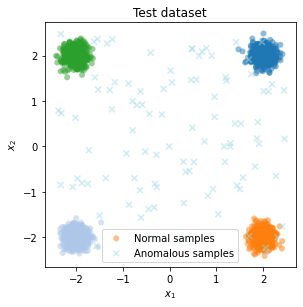

In [45]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

#### Z Test dataset

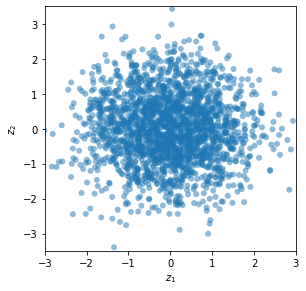

In [46]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

### Testing

In [47]:
feed_dict = {x: X_np_data_test, z:Z_np_data_test}
imz = sess.run(q_z, feed_dict=feed_dict)
rmz = sess.run(rec_z, feed_dict=feed_dict)
imx = sess.run(p_x, feed_dict=feed_dict)
rmx = sess.run(rec_x, feed_dict=feed_dict)

score_dz = sess.run(mahalanobis_dis_z, feed_dict=feed_dict)
score_dxx = sess.run(x_sigmoid_real + x_sigmoid_fake, feed_dict=feed_dict)

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims=False)
print(score)


[1.7612101  1.7839789  2.0917244  ... 1.2493982  1.7091345  0.04776285]


kernel estimation

In [57]:
from sklearn.neighbors import KernelDensity
import numpy as np
feed_dict_train = {x: X_dataset, z:Z_dataset}
imz_train = sess.run(q_z, feed_dict=feed_dict_train)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(imz_train)
score_kernel_train = kde.score_samples(imz_train)
score_kernel=kde.score_samples(imz)
print(score_kernel)

[-1.53656088 -1.53614981 -1.93904549 ... -4.50433015 -2.29477011
 -7.27295529]


hand written digit

In [49]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.datasets import load_digits
# from sklearn.neighbors import KernelDensity
# from sklearn.decomposition import PCA
# from sklearn.model_selection import GridSearchCV

# # load the data
# digits = load_digits()

# # project the 64-dimensional data to a lower dimension
# pca = PCA(n_components=15, whiten=False)
# data = pca.fit_transform(digits.data)

# # use grid search cross-validation to optimize the bandwidth
# params = {"bandwidth": np.logspace(-1, 1, 20)}
# grid = GridSearchCV(KernelDensity(), params)
# grid.fit(data)

# print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# # use the best estimator to compute the kernel density estimate
# kde = grid.best_estimator_

# # sample 44 new points from the data
# new_data = kde.sample(44, random_state=0)
# new_data = pca.inverse_transform(new_data)

# # turn data into a 4x11 grid
# new_data = new_data.reshape((4, 11, -1))
# real_data = digits.data[:44].reshape((4, 11, -1))

# # plot real digits and resampled digits
# fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
# for j in range(11):
#     ax[4, j].set_visible(False)
#     for i in range(4):
#         im = ax[i, j].imshow(
#             real_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
#         )
#         im.set_clim(0, 16)
#         im = ax[i + 5, j].imshow(
#             new_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
#         )
#         im.set_clim(0, 16)

# ax[0, 5].set_title("Selection from the input data")
# ax[5, 5].set_title('"New" digits drawn from the kernel density model')

# plt.show()

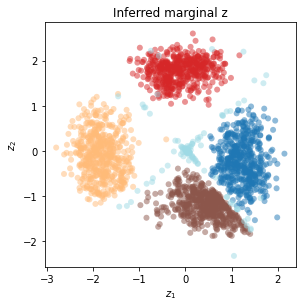

In [50]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

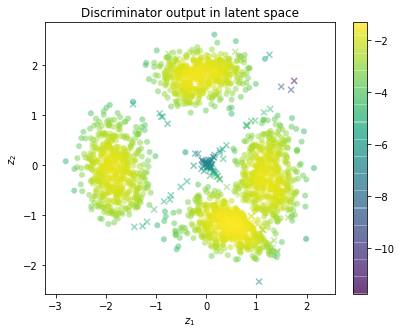

In [51]:
import matplotlib as mpl
## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score_kernel#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

In [61]:
idx_inliers = score_kernel <np.mean(score_kernel_train) 
idx_outliers = np.logical_not(idx_inliers)

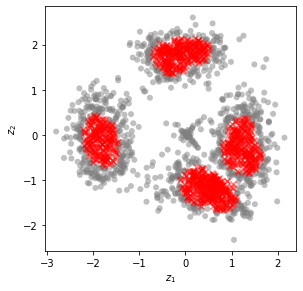

In [62]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

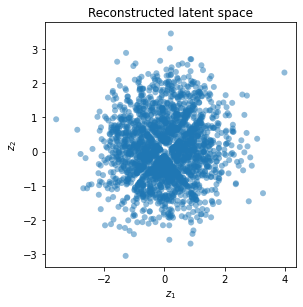

In [53]:
##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

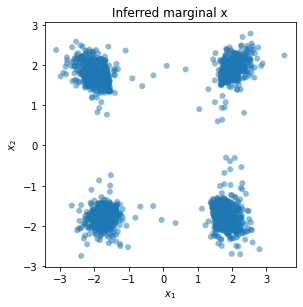

In [54]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

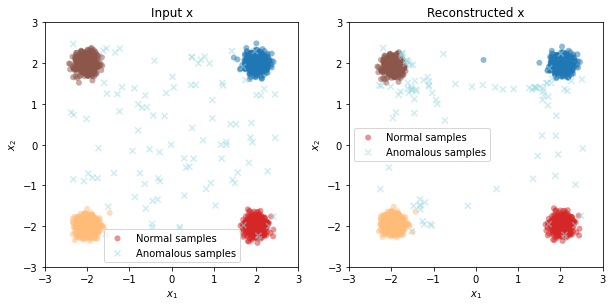

In [55]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

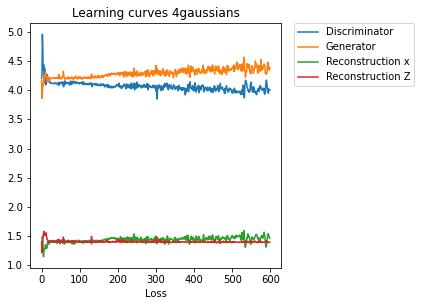

In [56]:
## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()